# Inference EfficientDet

Hi everyone!

My name is Alex Shonenkov, I am DL/NLP/CV/TS research engineer. Especially I am in Love with NLP & DL.

Recently I have created kernel for this competition about Weighted Boxes Fusion:
- [WBF approach for ensemble](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble)


I hope it is useful for you, my friends! If you didn't read this kernel, don't forget to do it! :)


Here I would like to share with you inference part for my training kernel:

- [[Training] EfficientDet](https://www.kaggle.com/shonenkov/training-efficientdet)

In [14]:
# !pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
# !pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [15]:
import sys
sys.path.insert(0, "timm-efficientdet-pytorch")
sys.path.insert(0, "weightedboxesfusion")
# sys.path.insert(0, "../input/omegaconf")

from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet

# Set environment
ENV = 'gcloud' 

# Set data directory
if ENV == 'gcloud':
    DIR_INPUT = 'data'
elif ENV == 'kaggle':
    DIR_INPUT = '../input/global-wheat-detection'
else:
    print("Error: invalid environment specified")
    
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [16]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [17]:
DATA_ROOT_PATH = DIR_TEST

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [18]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [19]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

# load in best checkpoint
net = load_net('effdet5-cutmix-augmix/best-checkpoint-023epoch.bin')

In [20]:
def make_predictions(images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.55, skip_box_thr=0.45, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

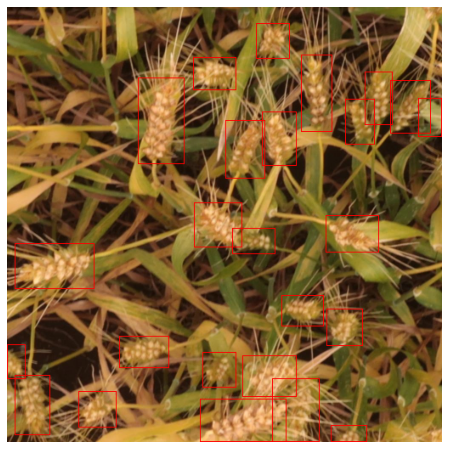

In [21]:
import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(data_loader):
    break

predictions = make_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample);

In [11]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [12]:
results = []

for images, image_ids in data_loader:
    predictions = make_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [13]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
0,cb8d261a3,0.9287 19 866 82 141 0.8992 308 167 109 201 0....
1,2fd875eaa,0.8952 105 583 144 87 0.8869 531 865 111 122 0...
2,aac893a91,0.8645 562 537 119 183 0.8248 28 454 99 150 0....
3,f5a1f0358,0.9041 943 435 80 182 0.8803 542 271 109 114 0...
4,796707dd7,0.9134 708 823 111 102 0.8594 503 785 93 101 0...


# Validation

In [44]:
import random
import os

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Set environment
ENV = 'gcloud' 

# Set data directory
if ENV == 'gcloud':
    DIR_INPUT = 'data'
elif ENV == 'kaggle':
    DIR_INPUT = '../input/global-wheat-detection'
else:
    print("Error: invalid environment specified")
    
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [45]:
marking = pd.read_csv(f'{DIR_INPUT}/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [46]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [47]:
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [48]:
TRAIN_ROOT_PATH = DIR_TRAIN

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [49]:
fold_number = 0

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

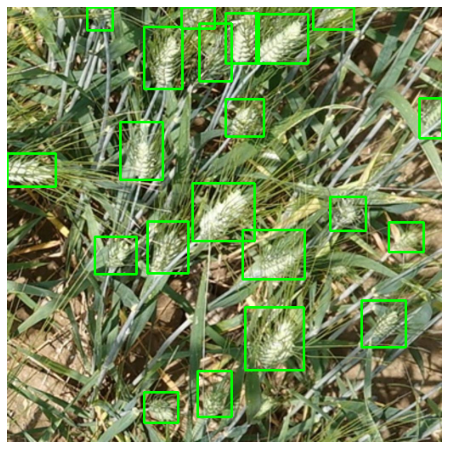

In [50]:
image, target, image_id = validation_dataset[2]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);